In [1]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import string
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2

from rnn_will import RNN, PrepareData

torch.cuda.is_available()

True

In [6]:
#input_dim = 7
"""
part d change dropout
"""
drop_ratio = 0.2
hidden_dim = 50
num_layers = 1
seq_size = 25
all_letters = string.printable
n_letters = len(all_letters)

In [7]:
dataset = PrepareData('../input.txt', seq_size, val_ratio=0.2)
#dataset = PrepareData('sample-music2.txt', seq_size)
train_data, val_data = dataset.dataset()
print(train_data.__len__(), val_data.__len__())

15688 3921


In [8]:
def inputTensor(line):
    if len(line) == 1:
        tensor = torch.zeros(1, n_letters)
        tensor[0, all_letters.find(line[0])] = 1
    else:
        tensor = torch.zeros(len(line)-1, n_letters)
        for idx, letter in enumerate(line[:-1]):
            tensor[idx, all_letters.find(letter)] = 1
    return Variable(tensor.cuda())
        
def targetTensor(line):
    letter_indexes = [all_letters.find(letter) for letter in line[1:]]
    return Variable(torch.LongTensor(letter_indexes).cuda())

def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [9]:
model = RNN(n_letters, hidden_dim, num_layers=num_layers, output_size=n_letters, drop_ratio=drop_ratio)
model = model.cuda()
criterion = nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
n_epochs = 15
all_losses = []

print_every = 2000
init_hidden_every = 35

start_time = time.time()

loss_history = np.zeros((n_epochs, 2))

for epoch in range(n_epochs):
    print('Epoch # {}'.format(epoch))
    train_cnt = 0
    total_loss = 0.
    running_loss = 0. #for checking purpose
    
    model.hidden = model.init_hidden()
    
    #dataset.shuffle_data()
    #train_data, val_data = dataset.dataset()
#     model.train(True)
    for sentence in train_data:
        model.zero_grad()
        
        loss = 0.
        inputs = inputTensor(sentence)
        targets = targetTensor(sentence)
        
        preds = model(inputs)
        loss = criterion(preds, targets)
            
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss
        train_cnt += 1
        
        if train_cnt % init_hidden_every == 0:
            model.hidden = model.init_hidden()
        
        if train_cnt % print_every == 0:
            total_loss /= print_every
            all_losses.append(total_loss)
            uptime = time.time() - start_time
            print('%dm:%ds -- [%d, %d], loss: %f' % (uptime/60, uptime%60, epoch, train_cnt, total_loss.data[0]))
            total_loss = 0
            
        running_loss += loss
    dataset_size = train_data.__len__()
    epoch_loss = running_loss / float(dataset_size)
    print('#, loss: {}'.format(epoch_loss))
            
#     model.train(False)
    for idx, dataloader in enumerate([train_data, val_data]):
        # compute loss
        running_loss = 0.
        for sentence in dataloader:
            loss = 0.
            inputs = inputTensor(sentence)
            targets = targetTensor(sentence)
            preds = model(inputs)
            loss = criterion(preds, targets)
            running_loss += loss.data[0]
            #
        # save loss
        dataset_size = dataloader.__len__()
        epoch_loss = running_loss / float(dataset_size)
        print('#{}, loss: {}'.format(idx, epoch_loss))
        # print(type(epoch_loss), type(epoch_acc))

        loss_history[epoch, idx] = epoch_loss
            
            
    scheduler.step()

Epoch # 0
0m:48s -- [0, 2000], loss: 3.088835
1m:38s -- [0, 4000], loss: 2.552830
2m:26s -- [0, 6000], loss: 2.150777
3m:15s -- [0, 8000], loss: 2.046539
4m:4s -- [0, 10000], loss: 1.836284
4m:55s -- [0, 12000], loss: 1.801843
5m:45s -- [0, 14000], loss: 1.819676
#, loss: Variable containing:
 2.1207
[torch.cuda.FloatTensor of size 1 (GPU 0)]

#0, loss: 2.5685789990583165
#1, loss: 3.3667527034829328
Epoch # 1
7m:46s -- [1, 2000], loss: 2.195151
8m:34s -- [1, 4000], loss: 2.086817
9m:21s -- [1, 6000], loss: 1.783132
10m:8s -- [1, 8000], loss: 1.764218
10m:57s -- [1, 10000], loss: 1.632750
11m:52s -- [1, 12000], loss: 1.632263
12m:43s -- [1, 14000], loss: 1.664883
#, loss: Variable containing:
 1.7864
[torch.cuda.FloatTensor of size 1 (GPU 0)]

#0, loss: 2.4709117785105668
#1, loss: 3.2605709320609284
Epoch # 2
14m:54s -- [2, 2000], loss: 2.004482
15m:45s -- [2, 4000], loss: 1.956818
16m:34s -- [2, 6000], loss: 1.662453
17m:24s -- [2, 8000], loss: 1.669388
18m:16s -- [2, 10000], loss: 1

In [11]:
# print(loss_history[8])

temp = np.concatenate((loss_history, np.array([loss_history[8]])), axis=0)
print(temp)
# print(all_losses)

[[ 2.67063644  3.3763115 ]
 [ 2.49499452  3.20083674]
 [ 2.42300944  3.12763692]
 [ 2.40567135  3.11331172]
 [ 2.40854176  3.1275137 ]
 [ 2.40196493  3.12615618]
 [ 2.30638868  2.99898691]
 [ 2.30016639  2.97397985]
 [ 2.29872055  2.96516224]
 [ 2.29920088  2.96051653]
 [ 2.30110986  2.95799984]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.29872055  2.96516224]]


In [12]:
fname = 'partc_drop_{}_loss_history.npy'.format(drop_ratio)
np.save(fname, temp)

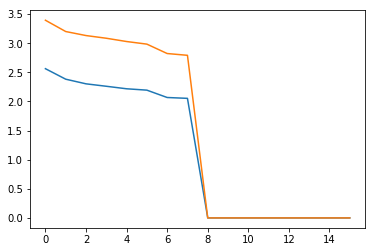

In [11]:
temp = np.load(fname)
plt.plot(range(16), temp)
plt.show()

In [ ]:
def test(start_with, max_length):
    model.hidden = model.init_hidden()
    seq = str(start_with)
    idx = []
    
    if len(start_with) > 1:
        inputs = inputTensor(seq)
        output = model(inputs)
    
    inputs = inputTensor(seq[-1])
    
    for i in range(max_length):
        output = model(inputs)
        #pr = F.softmax(output.data, 1)  //pytorch 3.0+
        pr = F.softmax(output.data)
        pr = pr.cpu().data.numpy().squeeze()
        pred = np.random.choice(n_letters, 1, p=pr)
        
        seq += all_letters[pred[0]]
        idx.append(pred[0])
        inputs = inputTensor(seq[-1])
    return seq, idx

def teacher_forcing_test(sentence):
    inputs = inputTensor(sentence)
    output = model(inputs)
    _, preds = torch.max(output.data, 1)
    seq = [all_letters[pred] for pred in preds ]
    return ''.join(seq)

In [ ]:
test_seq = val_data[0]
start_char = test_seq[:10]

seq, idx = test(start_char, 900)
print('Generated sequence: %s' % (seq))
#print('Sequence index: ', idx)
#print('Test sequence: %s' % test_seq)

In [ ]:
test_seq = val_data[99]
start_char = test_seq[:10]

seq, idx = test(start_char, 900)
print('Generated sequence: %s' % (seq))

In [ ]:
test_seq = val_data[0]
seq = teacher_forcing_test(test_seq)
print('Generated sequence: %s' % (seq))
print('Test sequence: %s' % test_seq)

In [ ]:
#save_model(model, 'full-model.pth')

In [ ]:
plt.figure()
plt.plot(all_losses)